In [111]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
import rioxarray
from mesma.core import mesma, hard_classification

In [172]:
def find_closest(arr: np.array or list, val: int or float):  
    """ 
    Find the closest value to a number and its corrsponding index in an array.

    :param arr: a np.array or list of numbers
    :param val: the number to find the closest value to 
    :return: the closest value and its index in arr
    """
    arr = np.asarray(arr)
    idx = (np.abs(arr - val)).argmin()

    return arr[idx], idx


def band_mask(wavelengths, mask_regions=[[1300,1500],[1800,2000]]):
    """
    Create a band mask for provided wavelength regions (default: water vapor regions at 1300-1500 nm and 1800-2000 nm.
    
    :param wavelengths: np.array of wavelengths
    :param bad_regions: list of lists containing the boundaries of the mask regions (default: [[1300,1500],[1800,2000]])
    :return: binary band mask (good bands are True, bad bands are False)
    """
    good_bands_mask = np.ones(wavelengths.shape, dtype=bool)
    for region in mask_regions:
        good_bands_mask = good_bands_mask * ~((wavelengths >= region[0]) & (wavelengths <= region[1]))
        
    return good_bands_mask


def prepare_image(fpath, 
                  mask_regions=[[300,400],[1300,1500],[1790,2000],[2400,2600]], 
                  scale_factor=10000, 
                  min_val=0, 
                  max_val=10000, 
                  no_data_pixels=-9999):
    """
    Prepare an image for MESMA.
    
    :param fpath: filepath to image
    :param mask regions: bad wavelength regions that should not be used for unmixing (default: wavelengths < 400 nm, water vapor bands at 1300-1500 nm and 1790-2000 nm, and wavelengths > 2400 nm)
    :param scale_factor: scale factor of reflectance data (MESMA requires values to be in range 0..1, default: 10000)
    :param min_val: lower boundary of accepted reflectance values, all values <= min_val will be set to no_data_pixels (default: 0)
    :param max_val: upper boundary of accepted reflectance values, all values > max_val will be set to no_data_pixels (default: 10000)
    :param no_data_pixels: value indicating no_data_pixels in MESMA (default: -9999)
    :return: 3D xarray.DataArray of shape (bands, spatial_x, spatial_y) with reflectance scales to range 0..1 and bands cropped to good wavelength regions
    """
    img = rioxarray.open_rasterio(fpath)
    img = img[band_mask(img.wavelength, mask_regions)] 
    return xr.where((img.min(dim='band')<=min_val) | (img.max(dim='band')>max_val), no_data_pixels*scale_factor, img).T / scale_factor   


def prepare_sli(fpath, 
                mask_regions=[[300,400],[1300,1500],[1790,2000],[2400,2600]], 
                scale_factor=1):
    """
    Prepare a spectral library for MESMA.
    
    :param fpath: filepath to SLI
    :param mask regions: bad wavelength regions that should not be used for unmixing (default: wavelengths < 400 nm, water vapor bands at 1300-1500 nm and 1790-2000 nm, and wavelengths > 2400 nm)
    :param scale_factor: scale factor of reflectance data (MESMA requires values to be in range 0..1, default: 10000)
    :return: two np.arrays:
        (1) 1D np.array of strings, a class for each endmember in the library 
        (2) 2D np.array of floats and shape (bands, endmembers) with reflectance scaled to range 0..1 and bands cropped to good wavelength regions
    """
    sli = pd.read_csv(fpath)
    class_list = sli.Planet.values
    em_spectra = sli[sli.columns[-428:][band_mask(sli.columns[-428:].astype(float), mask_regions)]] / scale_factor
    
    return class_list, em_spectra.T

In [462]:
img = prepare_image("C:\\Users\\mkoenig3\\Dropbox (ASU)\\Backup\\Downloads\\2022_PHX\\GAO\\GAO20220716t191531p0000\\GAO20220716t191531p0000_iacorn_refl_ort_sub.dat")
class_list, em_spectra = prepare_sli('C:\\Users\\mkoenig3\\Dropbox (ASU)\\Backup\\Downloads\\2022_PHX\\Spectral_Libraries\\Urban\\MaterialFractionalCover_SLI.csv')

C:\Users\mkoenig3\Anaconda3\envs\CarbonMapper_py3713\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (2,3,5,6,7,8,12,13,14,15,16,17,18,19,22,23,24,25,26,27,49) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [463]:
em_models = mesma.MesmaModels()
em_models.setup(class_list)
em_models.select_level(state=False, level=3)

In [479]:
import timeit

# Arrays to fill with chunks during for-loop
out_models = np.zeros((len(np.unique(class_list)), img.shape[1], img.shape[2])) * np.nan 
out_fractions = np.zeros((len(np.unique(class_list)) + 1, img.shape[1], img.shape[2])) * np.nan # + 1 for the shade fraction
out_rmse = np.zeros((img.shape[1], img.shape[2])) * np.nan
# list to store all MESMA information for each chunk
out_dicts = []

total_start = timeit.default_timer()

start_row = 0
split_size = 100 # number of rows per chunk to be unmixed

for chunk in range(start_row, img.shape[1], split_size):
    
    start = timeit.default_timer()
    
    ## Create MESMA object.
    MESMA = mesma.MesmaCore() # number of cores for parallel processing; the look-up-table of endmember combinations is split into n parts used for parallel unmixing, several image copies are stored in memory during unmixing.

    ## Execute MESMA.
    models, fractions, rmse, residuals = MESMA.execute(image = img[:, start_row:start_row+split_size, :].data, # image to be unmixed as np.array with shape (spatial_x, spatial_y, bands), needs to have same band setting as library and reflectance values ranging 0..1.
                                            library = em_spectra, # endmember spectra as 2D np.array (spectra as columns), needs to have same band setting as image and reflectance values ranging 0..1.               
                                            look_up_table = em_models.return_look_up_table(), # all endmember combinations (=models) for MESMA; ordered per complexity level and perclass-model; n_models x n_endmembers
                                            em_per_class = em_models.em_per_class, # a list of all library indices per endmember class
                                            constraints = (-0.05, 1.05, -0.1, 0.8, 0.05, -9999, -9999)# , # min + max endmember fraction, min + max shade fraction, max rmse, residual reflectance threshold + max number of consecutive bands exceeding threshold. set value to -9999 if not used, default: (-0.05, 1.05, 0., 0.8, 0.025, -9999, -9999)
                                            # no_data_pixels = np.where(img_chunk==-9999), # indices of pixels that contain no data (result of np.where)
                                            # shade_spectrum = None#, # single spectrum of photometric shade: default: None
                                            # fusion_value = 0.01, # only select a model of higher complexity (e.g. 3-EM over 2-EM) of the RMSE is better with at least this value, default: 0.007
                                            # residual_image = False, # output the residuals as an image (ignored when using band weighing or -selection), default: False
                                            # use_band_weighing = False, # use the weighted linear spectral mixture analysis (Somers et al, 2009), default: False
                                            # use_band_selection = False # use the bands selection algorithm (Somers et al, 2010), default: False
                                            # bands_selection_values = (0.99, 0.01) # correlation threshold and decrease for the band selection algorithm, default: (0.99, 0.01)
                                           )
    
    out_models[:, start_row:start_row + split_size, :] = models
    out_fractions[:, start_row:start_row + split_size, :] = fractions
    out_rmse[start_row:start_row + split_size,:] = rmse
    out_dicts.append(MESMA.__dict__)
    
    start_row = start_row + split_size
    
    stop = timeit.default_timer()
    print('Chunk Time: ', stop - start)  
    
total_stop = timeit.default_timer()
print('Total Time: ', total_stop - total_start)  

processing 2-EM models..Chunk Time:  266.5525772999972
processing 2-EM models..Chunk Time:  275.90155319997575
processing 2-EM models..Chunk Time:  298.73260290001053
processing 2-EM models..Chunk Time:  345.9686109999893
processing 2-EM models..Chunk Time:  320.6663501000148
processing 2-EM models..

KeyboardInterrupt: 

In [484]:
em_spectra[np.where(np.isnan(em_spectra.values))[1]]

1130      1131      1132      1133      1137      1143  \
402.380005        NaN       NaN       NaN       NaN       NaN       NaN   
407.380005        NaN       NaN       NaN       NaN       NaN       NaN   
412.390015        NaN       NaN       NaN       NaN       NaN       NaN   
417.399994   0.002912  0.002861  0.001818  0.001561  0.002509  0.000282   
422.410004   0.002858  0.002805  0.001908  0.001337  0.002404  0.000369   
...               ...       ...       ...       ...       ...       ...   
2375.330078  0.002868  0.001979  0.002498  0.003172  0.002954  0.000517   
2380.340088  0.002868  0.001979  0.002498  0.003172  0.002954  0.000517   
2385.350098  0.002868  0.001979  0.002498  0.003172  0.002954  0.000517   
2390.350098  0.002802  0.001953  0.002474  0.003161  0.002925  0.000528   
2395.360107  0.002756  0.001935  0.002456  0.003154  0.002904  0.000536   

                 1144      1145      1146      1150  ...      1137      1143  \
402.380005        NaN       NaN       NaN       NaN  ...       NaN       NaN   
407.380005        NaN       NaN       NaN       NaN  ...       NaN       NaN   
412.390015        NaN       NaN       NaN       NaN  ...       NaN       NaN   
417.399994   0.000391  0.000208  0.000283  0.001768  ...  0.002509  0.000282   
422.410004   0.000434  0.000319  0.000304  0.001759  ...  0.002404  0.000369   
...               ...       ...       ...       ...  ...       ...       ...   
2375.330078  0.000451  0.000441  0.000422  0.003023  ...  0.002954  0.000517   
2380.340088  0.000451  0.000441  0.000422  0.003023  ...  0.002954  0.000517   
2385.350098  0.000451  0.000441  0.000422  0.003023  ...  0.002954  0.000517   
2390.350098  0.000457  0.000446  0.000426  0.003038  ...  0.002925  0.000528   
2395.360107  0.000460  0.000449  0.000429  0.003048  ...  0.002904  0.000536   

                 1144      1145      1146      1150      1151      1152  \
402.380005        NaN       NaN       NaN       NaN       NaN       NaN   
407.380005        NaN       NaN       NaN       NaN       NaN       NaN   
412.390015        NaN       NaN       NaN       NaN       NaN       NaN   
417.399994   0.000391  0.000208  0.000283  0.001768  0.000408  0.000560   
422.410004   0.000434  0.000319  0.000304  0.001759  0.000456  0.000517   
...               ...       ...       ...       ...       ...       ...   
2375.330078  0.000451  0.000441  0.000422  0.003023  0.001412  0.001244   
2380.340088  0.000451  0.000441  0.000422  0.003023  0.001412  0.001244   
2385.350098  0.000451  0.000441  0.000422  0.003023  0.001412  0.001244   
2390.350098  0.000457  0.000446  0.000426  0.003038  0.001412  0.001246   
2395.360107  0.000460  0.000449  0.000429  0.003048  0.001411  0.001248   

                 1154      1155  
402.380005        NaN       NaN  
407.380005        NaN       NaN  
412.390015        NaN       NaN  
417.399994   0.000452  0.000863  
422.410004   0.000507  0.000809  
...               ...       ...  
2375.330078  0.000545  0.000720  
2380.340088  0.000545  0.000720  
2385.350098  0.000545  0.000720  
2390.350098  0.000545  0.000713  
2395.360107  0.000544  0.000708  

[317 rows x 42 columns]

In [406]:
classification = hard_classification.HardClassification().execute(out_fractions)

In [468]:
x=[]
x.append({'a'})

In [469]:
x

[{'a'}]

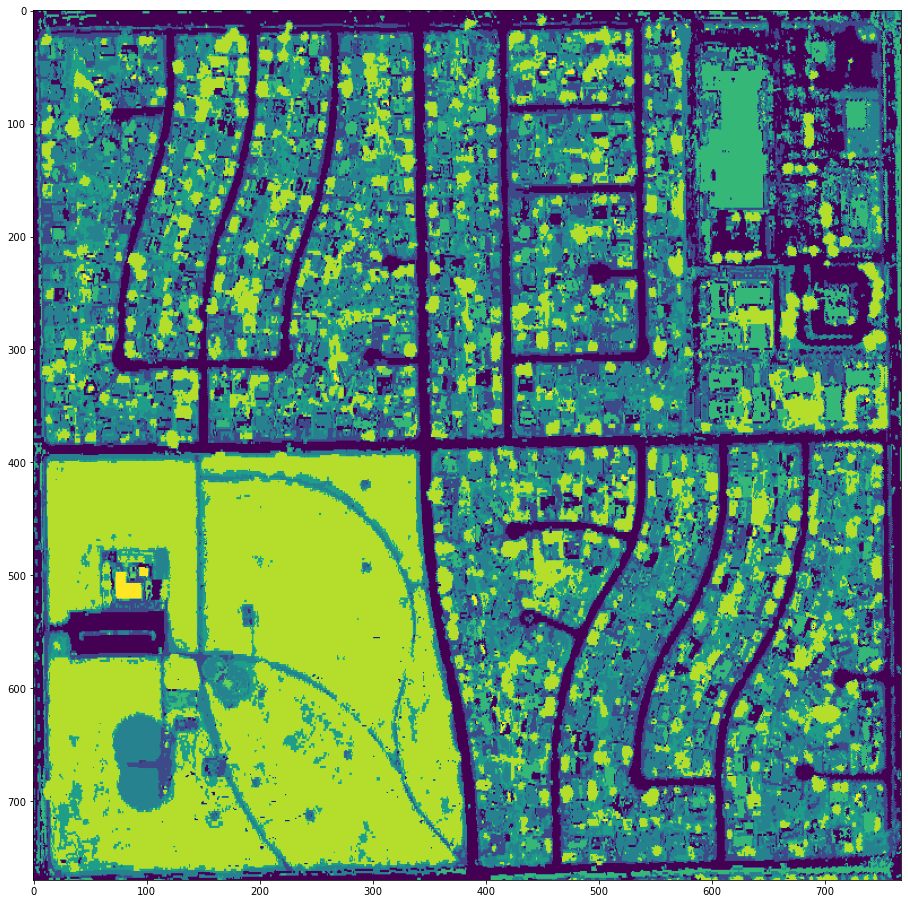

In [415]:
plt.figure(figsize=(16,16))
plt.imshow(classification)

# Old stuff

In [408]:
comb = np.append(out_models, out_fractions, axis=0)
comb = np.append(comb, np.moveaxis(out_rmse[..., np.newaxis],[0,1,2],[1,2,0]), axis=0)

In [418]:
comb.shape

(22, 770, 768)

In [64]:
import pickle

with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_23EM.pkl",'rb') as f:
    mesma_res = pickle.load(f)

In [420]:
models = comb[0:10]
fractions = comb[10:20]
rmse = comb[21]

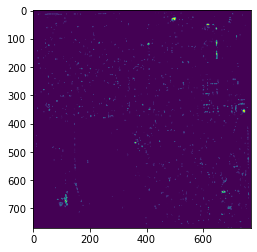

In [66]:
plt.imshow(models[1,:,:])

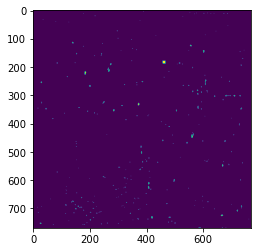

In [67]:
n = np.moveaxis(rmse[..., np.newaxis],[0,1,2],[1,2,0])

plt.imshow(n[0,:,:])

In [68]:
comb = np.append(models, fractions, axis=0)
comb = np.append(comb, np.moveaxis(rmse[..., np.newaxis],[0,1,2],[1,2,0]), axis=0)

In [72]:
from mesma.core.hard_classification import HardClassification

classification = HardClassification().execute(fractions)

In [76]:
np.moveaxis(classification[..., np.newaxis],[0,1,2],[1,2,0]).shape

(1, 769, 769)

In [77]:
comb = np.append(comb, np.moveaxis(classification[..., np.newaxis],[0,1,2],[1,2,0]), axis=0)

In [417]:
models.shape

(770, 768)

# Models

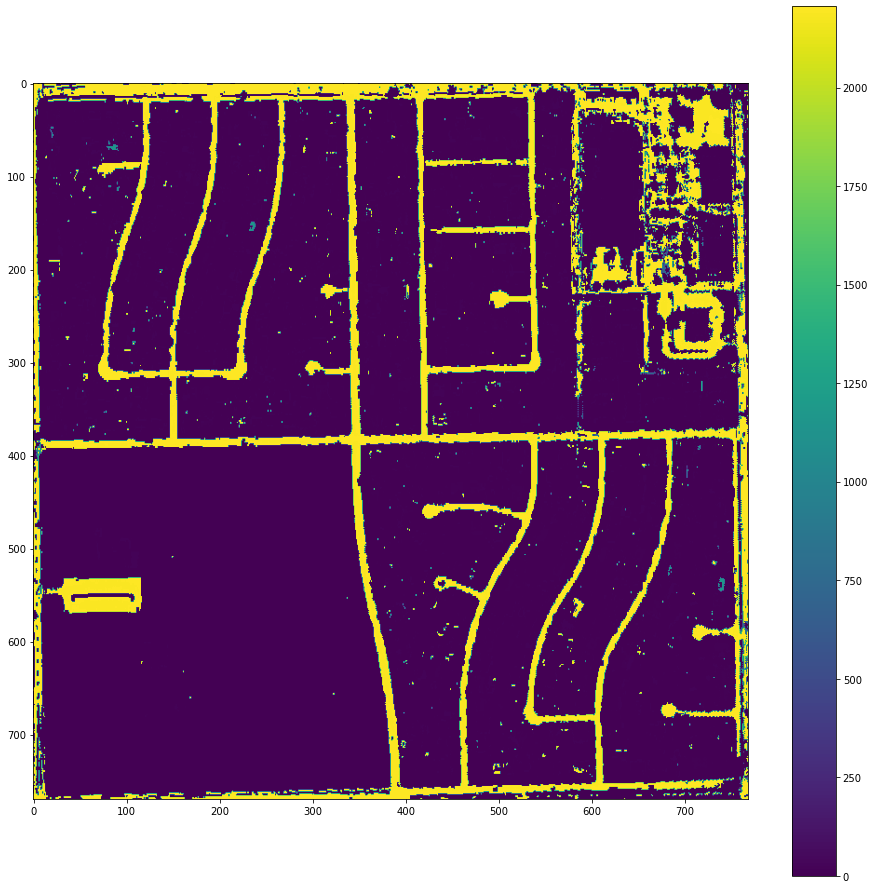

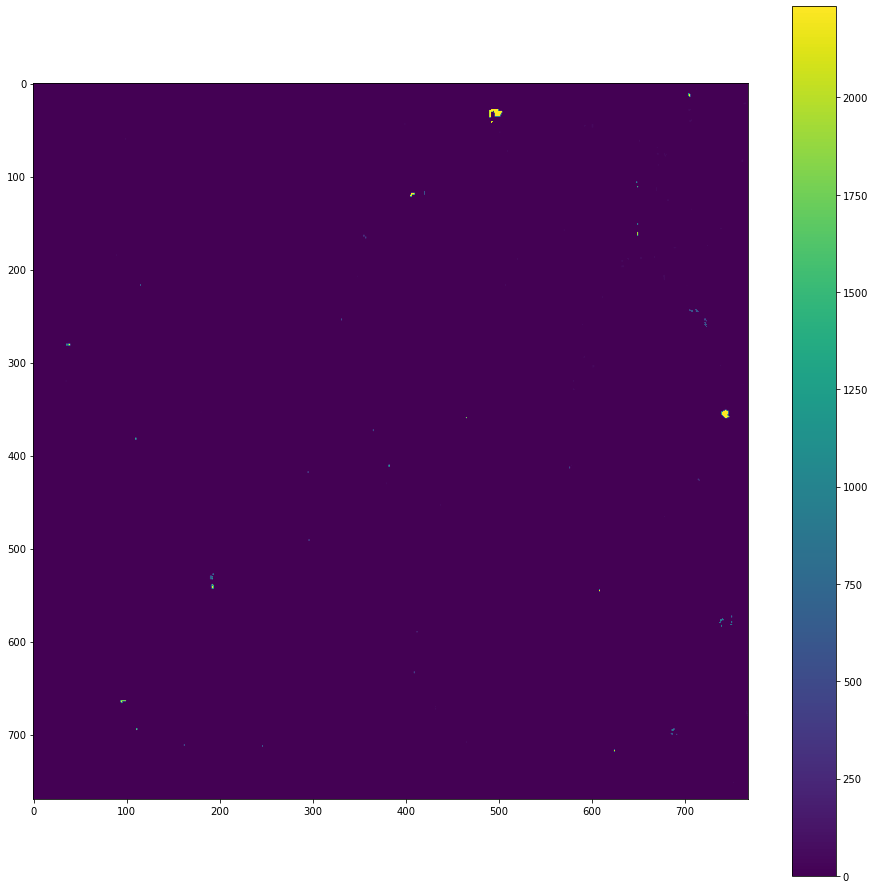

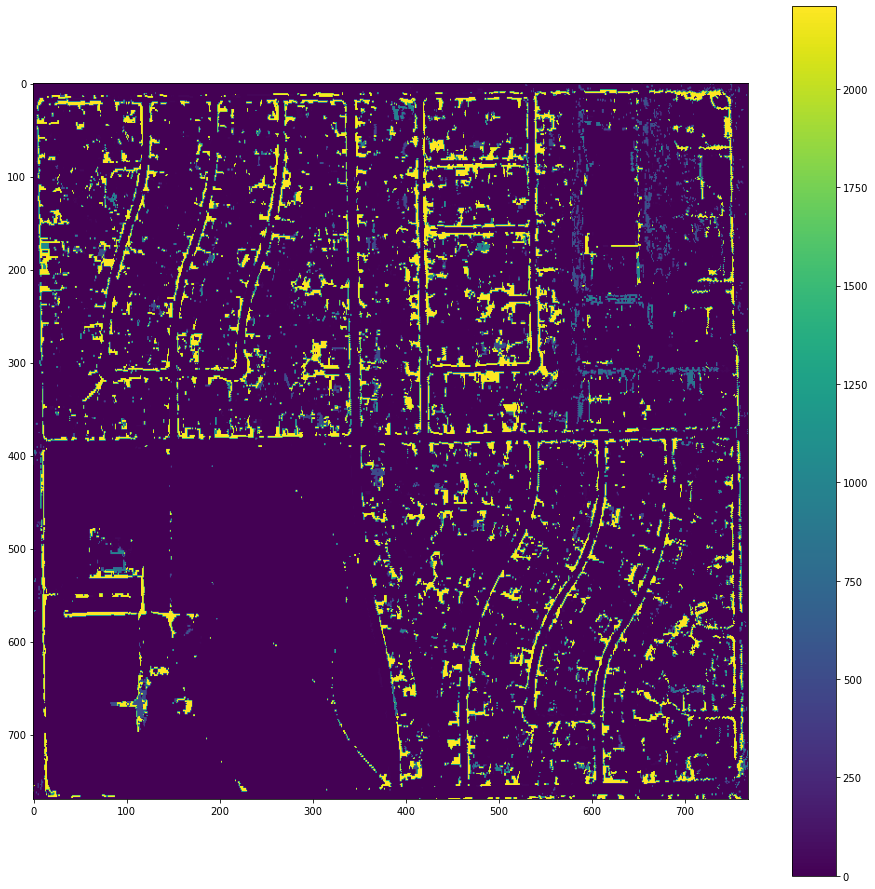

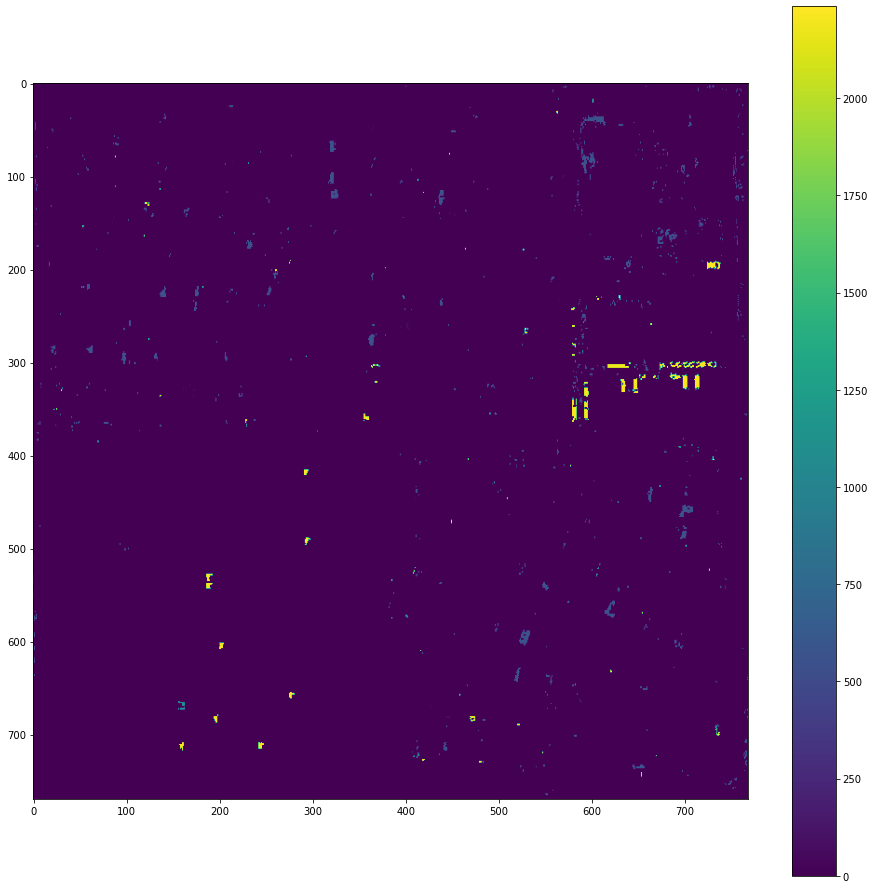

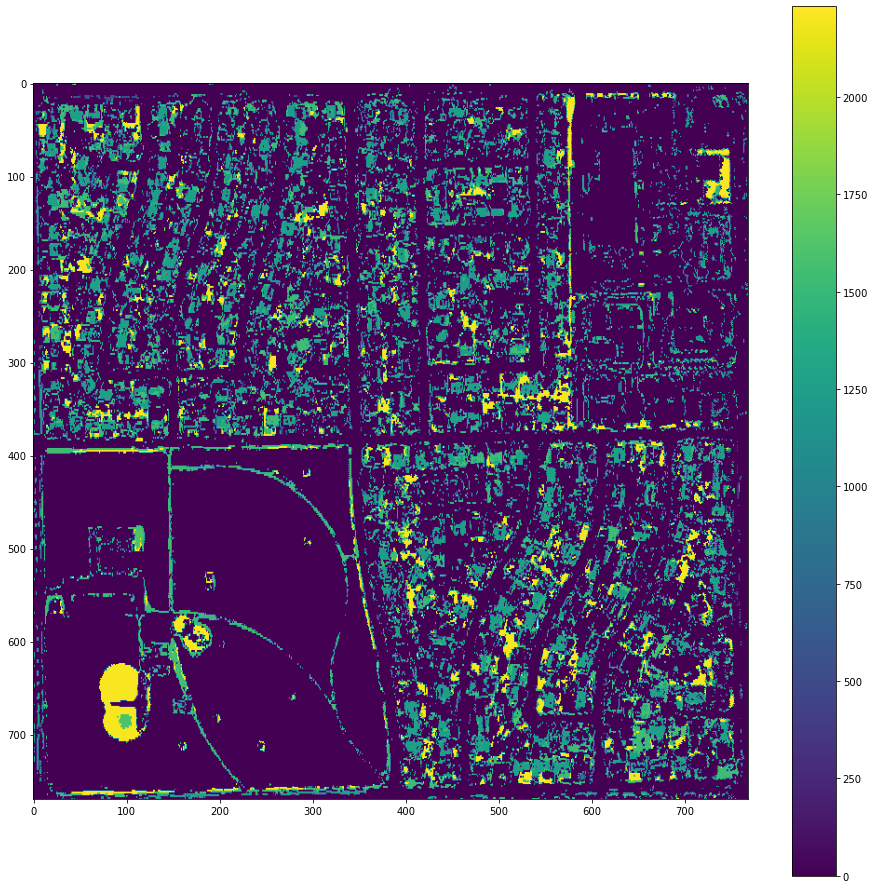

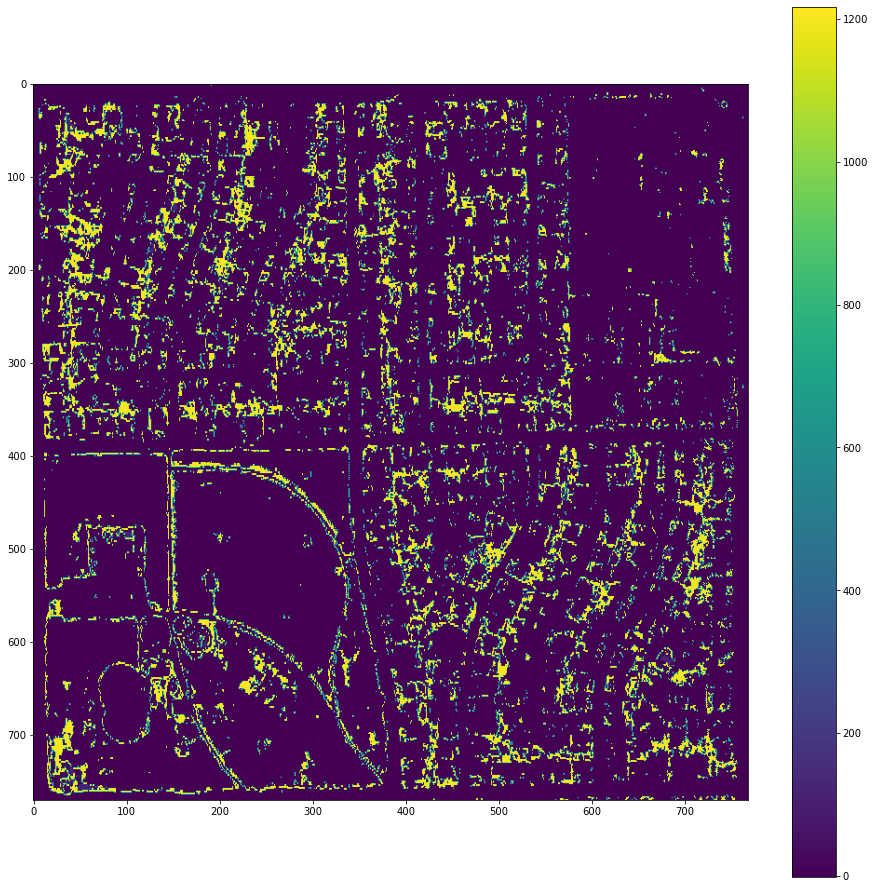

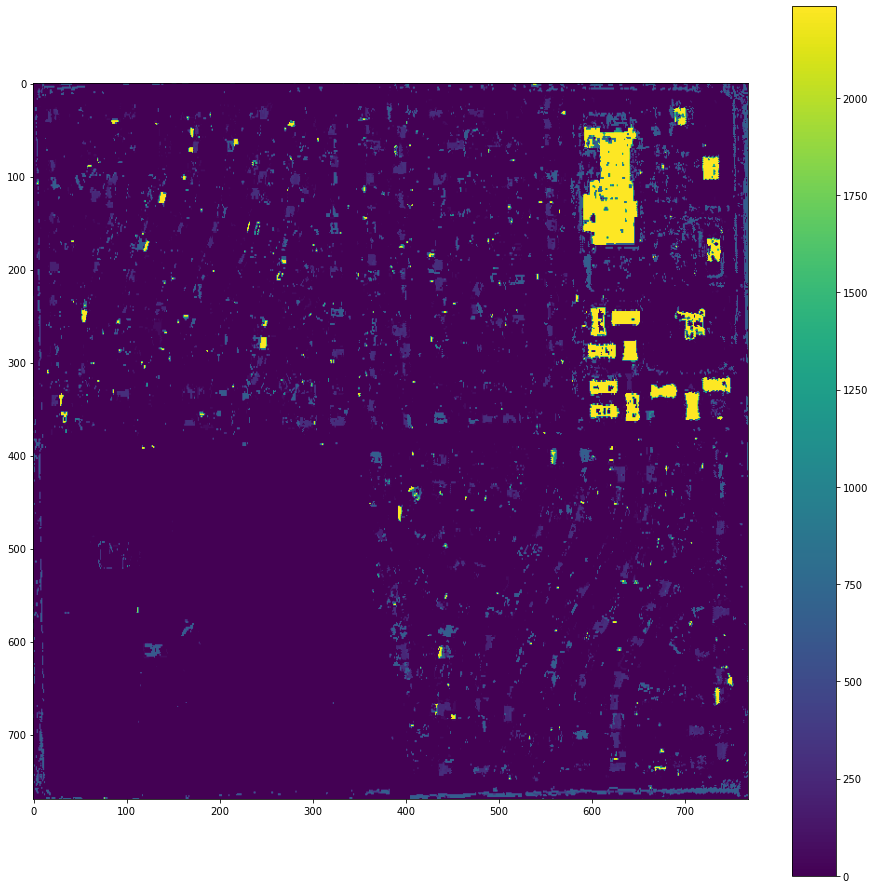

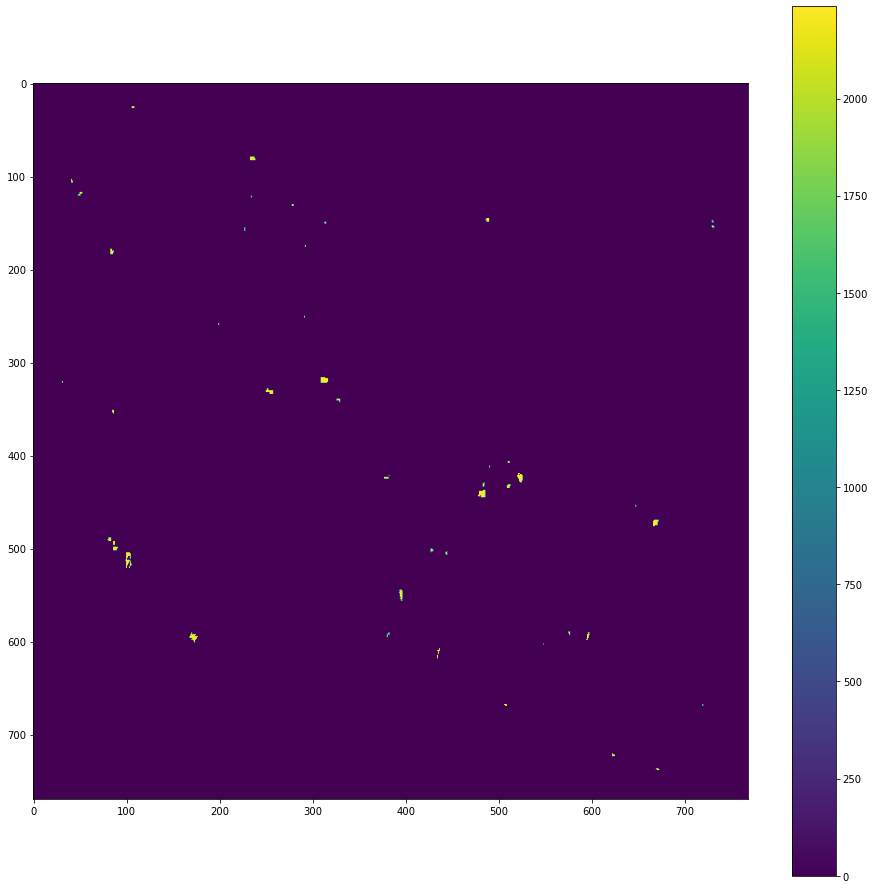

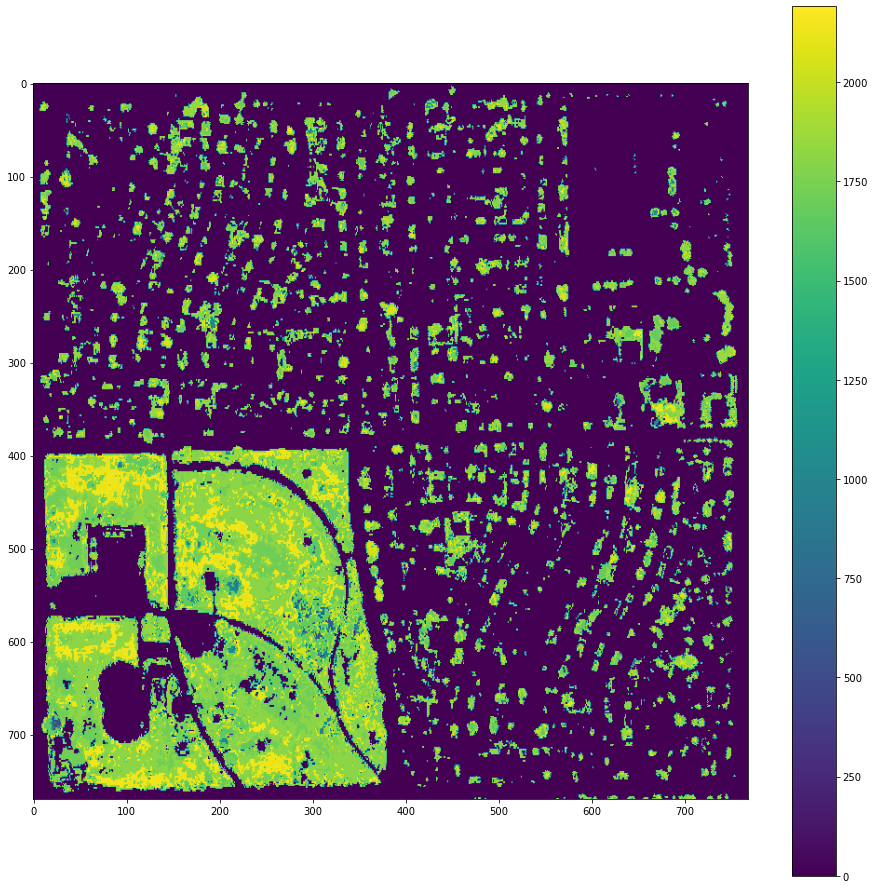

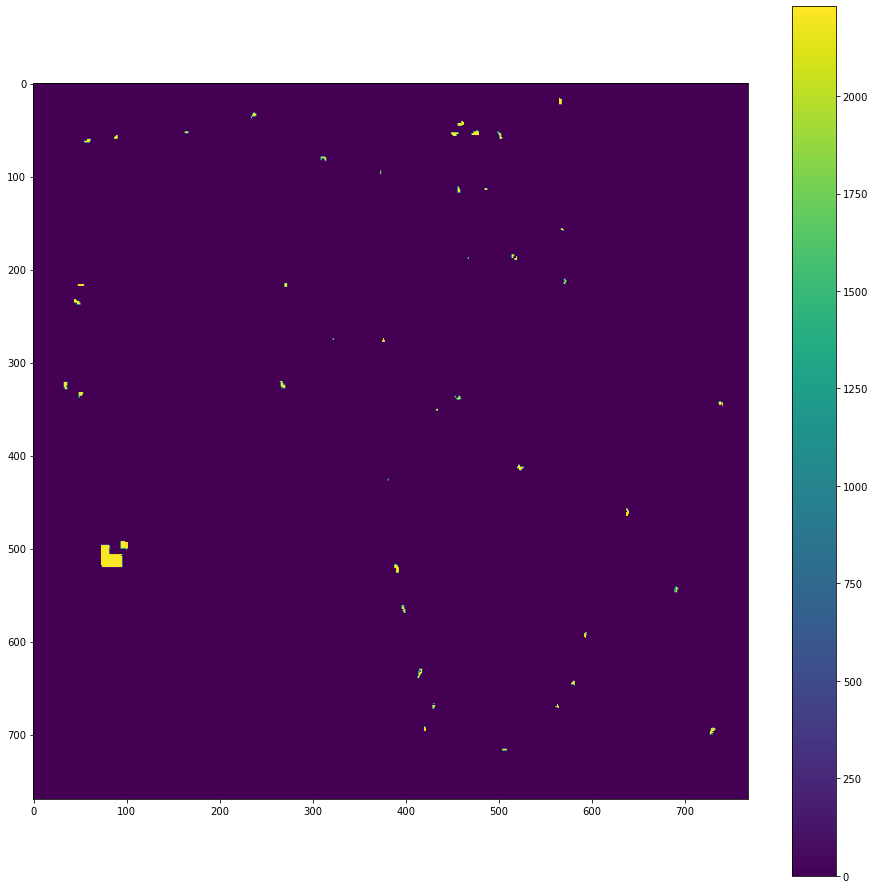

In [421]:
for mod in np.arange(models.shape[0]):
    plt.figure(figsize=(16,16))
    plt.imshow(models[mod,:,:])
    plt.colorbar()
    # plt.title("fractional cover of " + np.append(MESMA_model.unique_classes, "shade")[frac])
    plt.show()

# Fractions

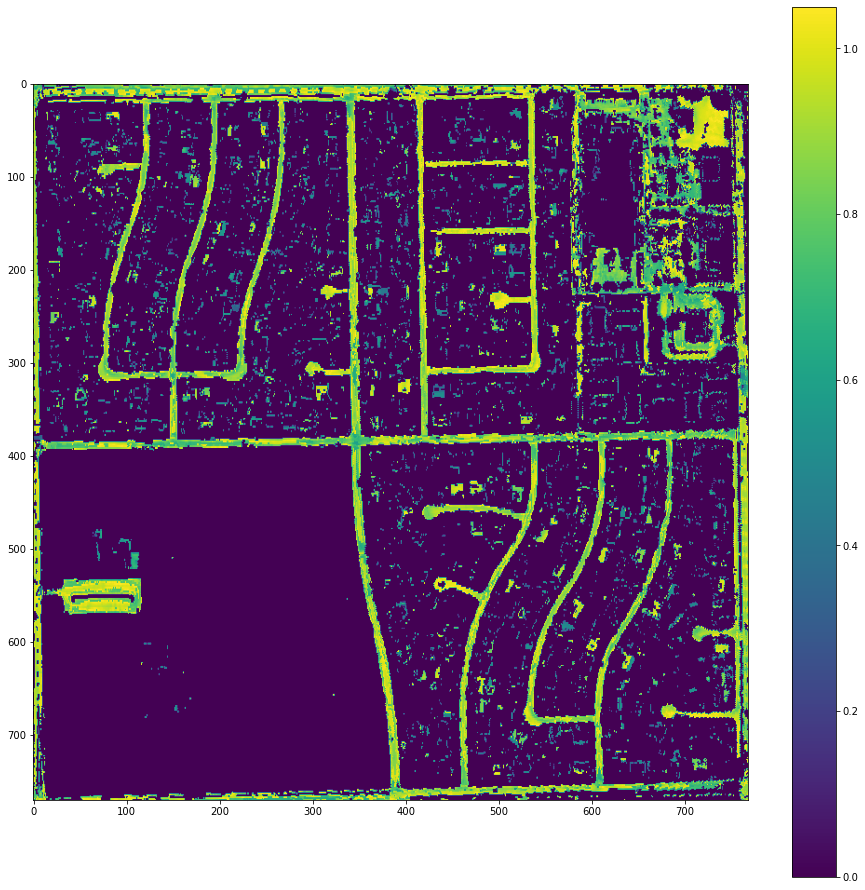

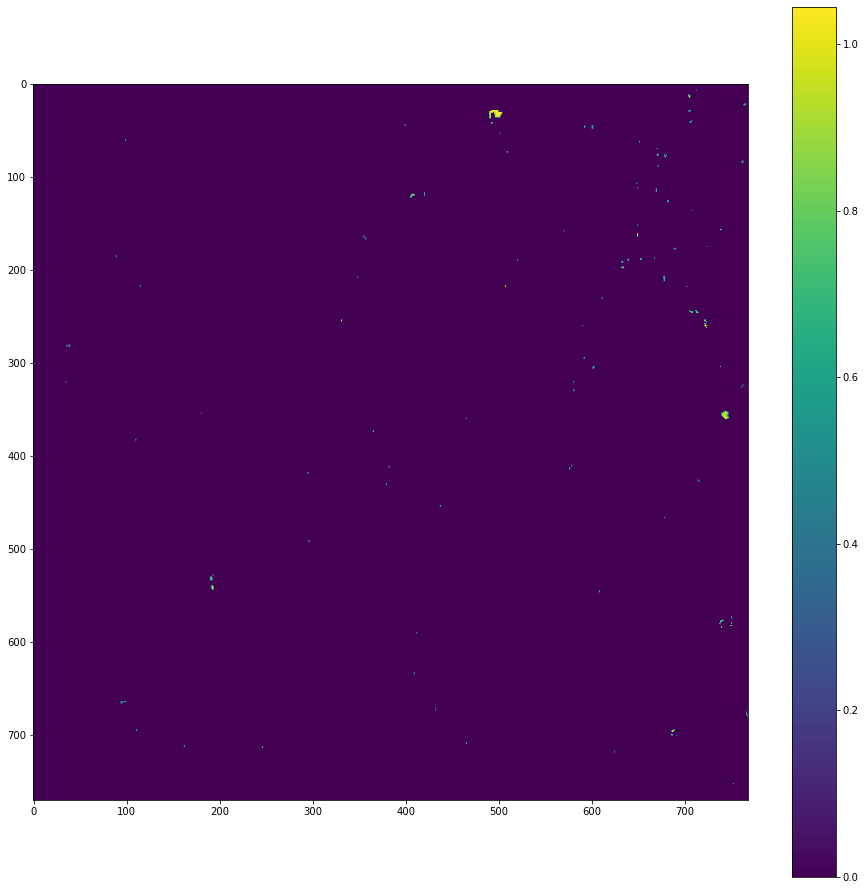

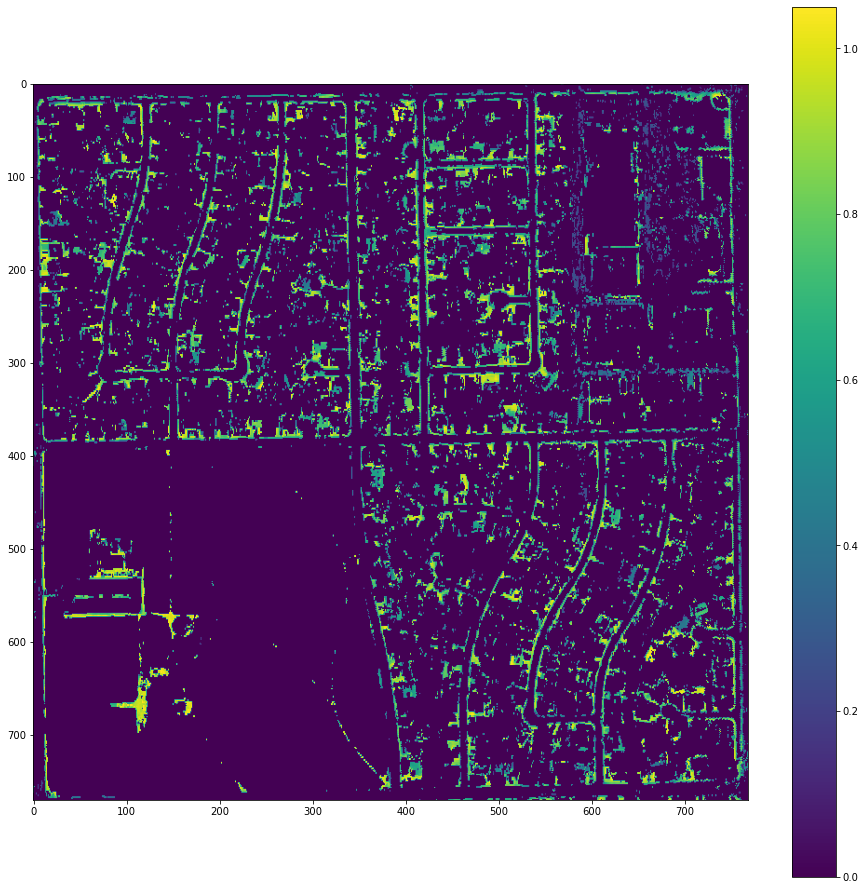

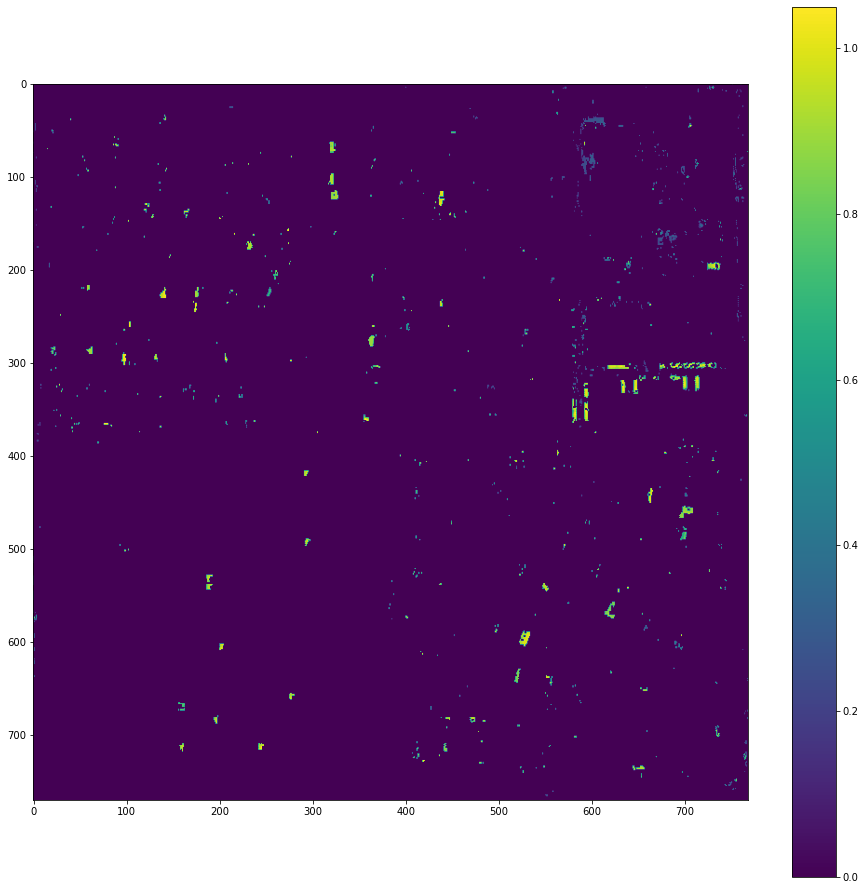

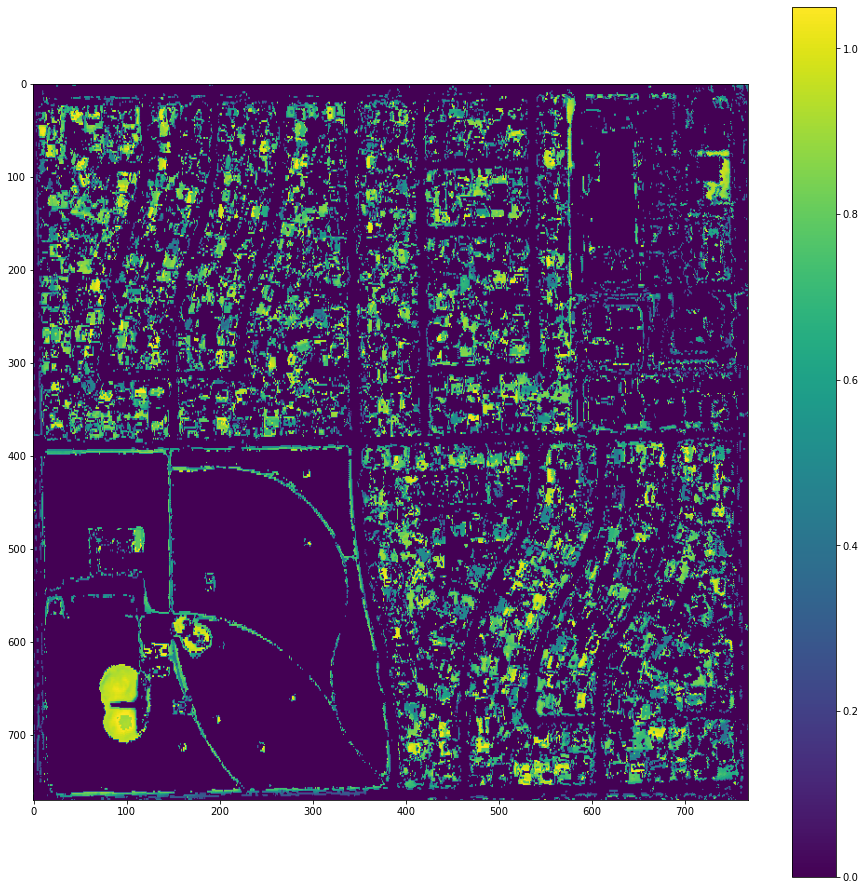

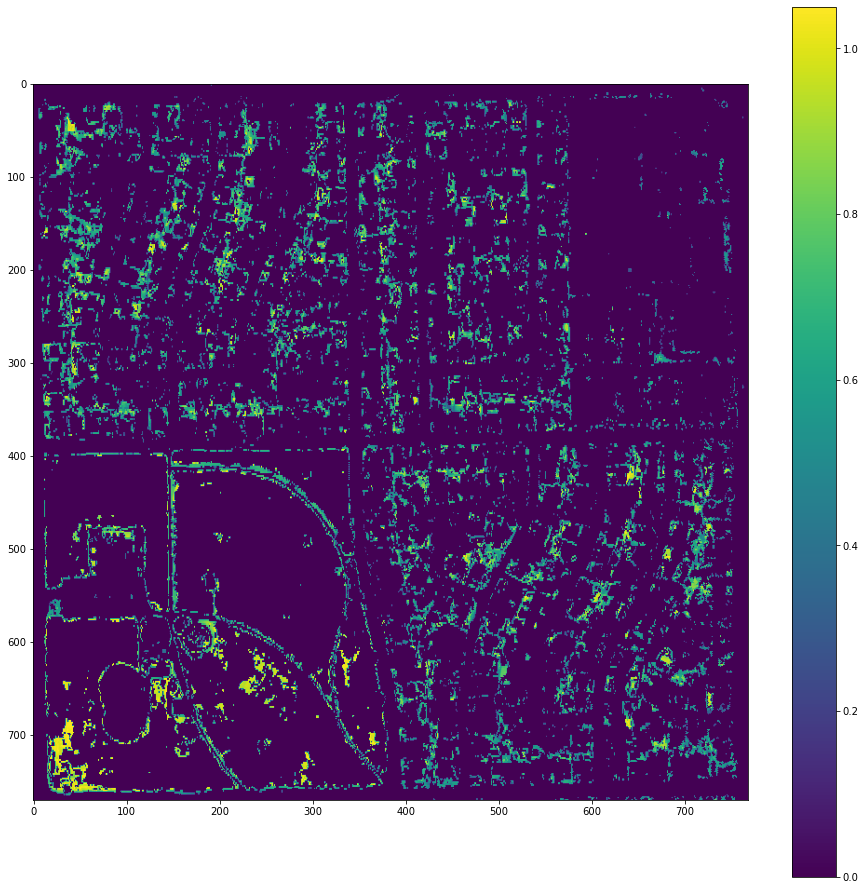

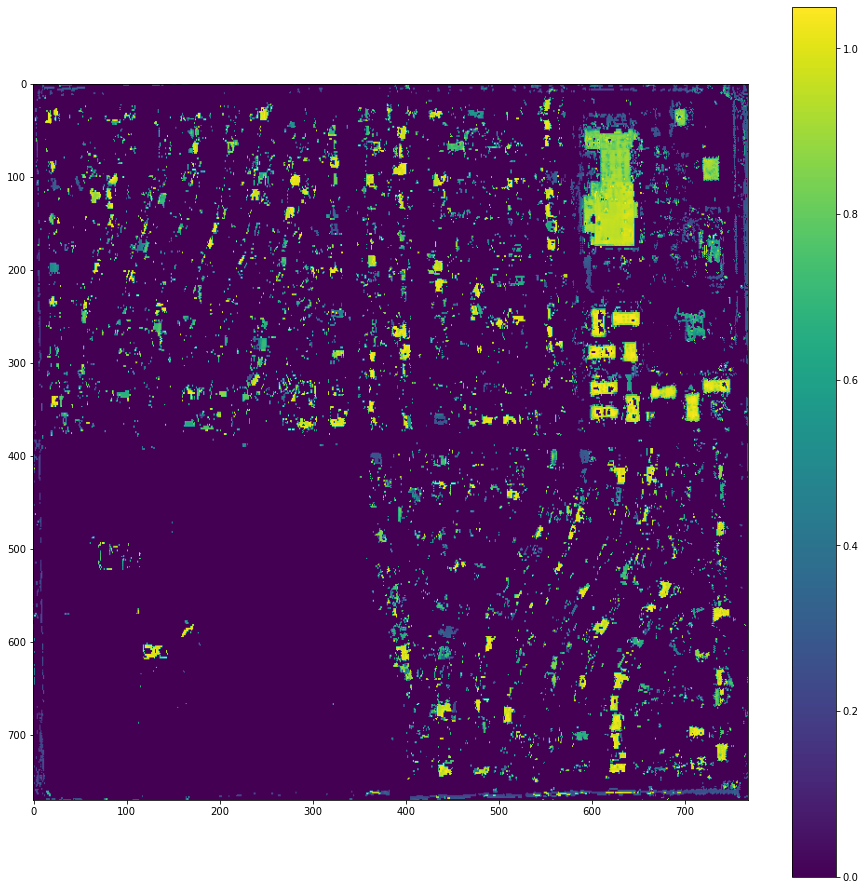

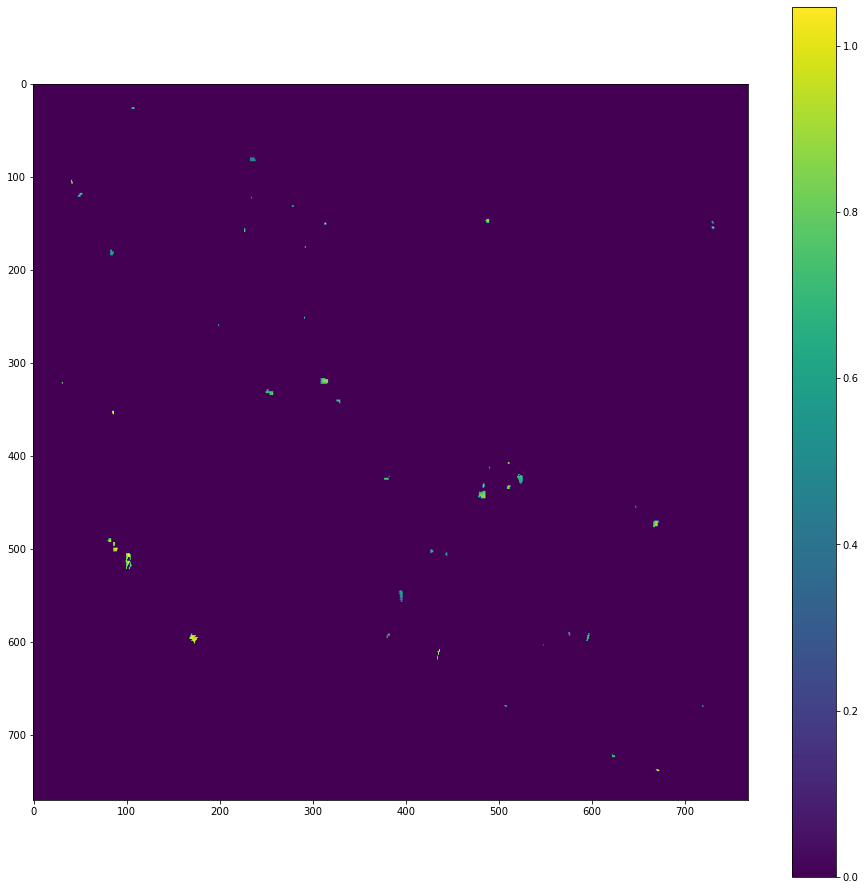

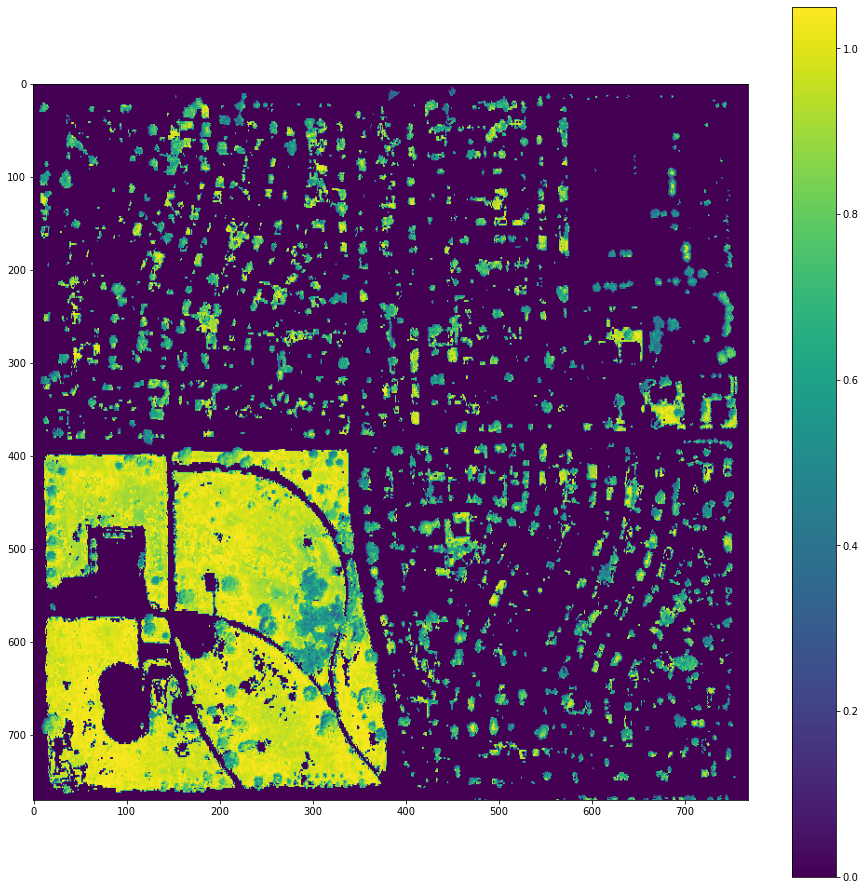

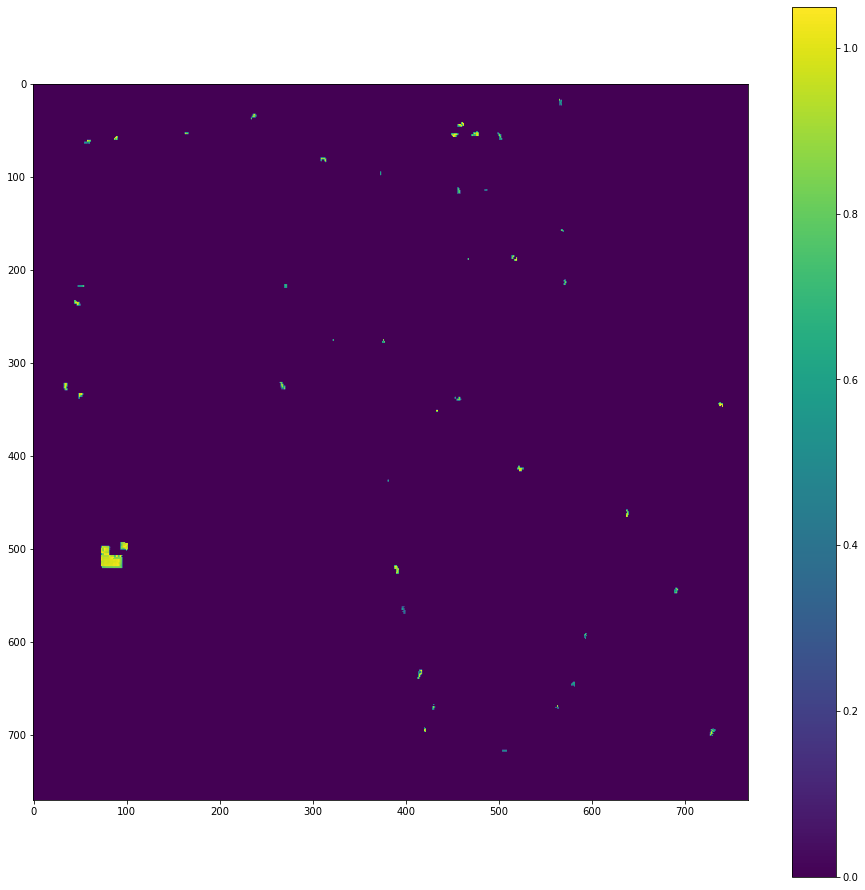

In [422]:
for frac in np.arange(fractions.shape[0]):
    plt.figure(figsize=(16,16))
    plt.imshow(fractions[frac,:,:])
    plt.colorbar()
    # plt.title("fractional cover of " + np.append(MESMA_model.unique_classes, "shade")[frac])
    plt.show()

# RMSE

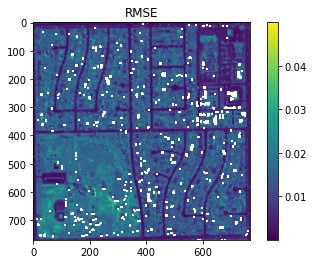

In [425]:
#plt.figure(figsize=(16,16))
plt.imshow(np.where(rmse==9999, np.nan, rmse))
plt.colorbar()
plt.title('RMSE')
plt.show()

# Save to disk

In [15]:
# read image profile (ENVI header data)
profile = img.rio._manager.acquire().profile

In [80]:
profile["dtype"] = 'float64'
profile["count"] = comb.shape[0]

In [83]:
# use rasterio to write file to disk
with rasterio.open("C:\\Users\\mkoenig3\\Dropbox (ASU)\\Backup\\Downloads\\2022_PHX\\SOL\\COMBINED_SLI_ALL_COLS_PHX_23EM.dat", "w", **profile) as dst:
    dst.write(comb.transpose(0,2,1))

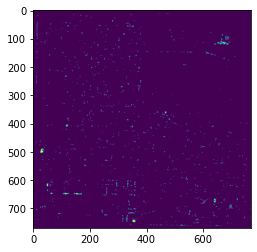

In [82]:
plt.imshow(comb.transpose(0,2,1)[1])

In [39]:
profile

{'driver': 'ENVI', 'dtype': 'float64', 'nodata': -9999.0, 'width': 769, 'height': 769, 'count': 22, 'crs': CRS.from_epsg(32612), 'transform': Affine(1.05, -0.0, 389776.8,
       -0.0, -1.05, 3705990.75), 'tiled': False, 'interleave': 'line'}

# Shade test

In [27]:
import pickle

with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-0.1, 0.1).pkl",'rb') as f:
    shade01 = pickle.load(f)
    
with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-0.2, 0.2).pkl",'rb') as f:
    shade02 = pickle.load(f)

with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-0.3, 0.3).pkl",'rb') as f:
    shade03 = pickle.load(f)
    
with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-0.4, 0.4).pkl",'rb') as f:
    shade04 = pickle.load(f)
    
with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-0.5, 0.5).pkl",'rb') as f:
    shade05 = pickle.load(f)
    
with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-0.6, 0.6).pkl",'rb') as f:
    shade06 = pickle.load(f)
    
with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-0.7, 0.7).pkl",'rb') as f:
    shade07 = pickle.load(f)
    
with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-0.8, 0.8).pkl",'rb') as f:
    shade08 = pickle.load(f)
    
with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-0.9, 0.9).pkl",'rb') as f:
    shade09 = pickle.load(f)
    
with open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\Research\\Researcher\\Koenig\\2022_PHX\\COMBINED_SLI_ALL_COLS_PHX_2EM_(-1.0, 1.0).pkl",'rb') as f:
    shade10 = pickle.load(f)

In [28]:
SI01 = np.abs(np.where(shade01[1][-1]==0,1,shade01[1][-1])) * shade01[2]
SI02 = np.abs(np.where(shade02[1][-1]==0,1,shade02[1][-1])) * shade02[2]
SI03 = np.abs(np.where(shade03[1][-1]==0,1,shade03[1][-1])) * shade03[2]
SI04 = np.abs(np.where(shade04[1][-1]==0,1,shade04[1][-1])) * shade04[2]
SI05 = np.abs(np.where(shade05[1][-1]==0,1,shade05[1][-1])) * shade05[2]
SI06 = np.abs(np.where(shade06[1][-1]==0,1,shade06[1][-1])) * shade06[2]
SI07 = np.abs(np.where(shade07[1][-1]==0,1,shade07[1][-1])) * shade07[2]
SI08 = np.abs(np.where(shade08[1][-1]==0,1,shade08[1][-1])) * shade08[2]
SI09 = np.abs(np.where(shade09[1][-1]==0,1,shade09[1][-1])) * shade09[2]
SI10 = np.abs(np.where(shade10[1][-1]==0,1,shade10[1][-1])) * shade10[2]

In [115]:
# shade = np.where(np.abs(shade10[1][-1])<np.abs(shade09[1][-1]), np.abs(shade10[1][-1]), 
#                     np.where(np.abs(shade09[1][-1])<np.abs(shade08[1][-1]), np.abs(shade09[1][-1]),
#                              np.where(np.abs(shade08[1][-1])<np.abs(shade07[1][-1]), np.abs(shade08[1][-1]),
#                                       np.where(np.abs(shade07[1][-1])<np.abs(shade06[1][-1]), np.abs(shade07[1][-1]),
#                                                np.where(np.abs(shade06[1][-1])<np.abs(shade05[1][-1]), np.abs(shade06[1][-1]),
#                                                         np.where(np.abs(shade05[1][-1])<np.abs(shade04[1][-1]), np.abs(shade05[1][-1]),
#                                                                  np.where(np.abs(shade04[1][-1])<np.abs(shade03[1][-1]), np.abs(shade04[1][-1]),
#                                                                           np.where(np.abs(shade03[1][-1])<np.abs(shade02[1][-1]), np.abs(shade03[1][-1]),
#                                                                                    np.where(np.abs(shade02[1][-1])<np.abs(shade01[1][-1]), np.abs(shade02[1][-1]), np.abs(shade01[1][-1]))))))))))
# plt.imshow(shade)
# plt.colorbar()

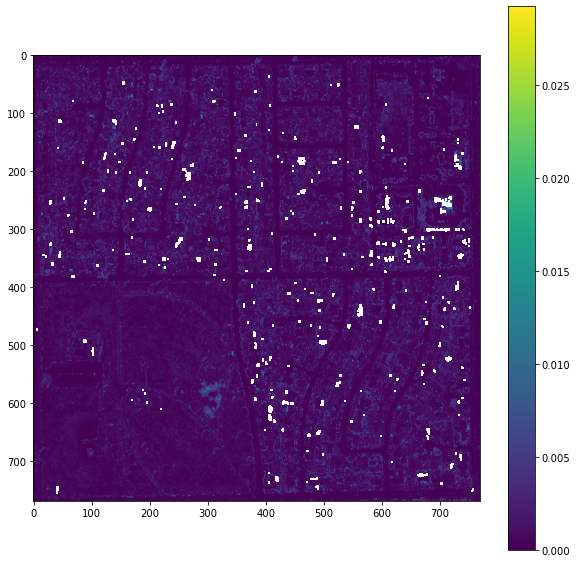

In [29]:
SI = np.where(SI10<SI09, SI10, 
                    np.where(SI09<SI08, SI09, 
                             np.where(SI08<SI07, SI08, 
                                      np.where(SI07<SI06, SI07, 
                                               np.where(SI06<SI05, SI06, 
                                                        np.where(SI05<SI04, SI05, 
                                                                 np.where(SI04<SI03, SI04, 
                                                                          np.where(SI03<SI02, SI03,
                                                                                   np.where(SI02<SI01, SI02, SI01)))))))))
plt.figure(figsize=(10,10))
plt.imshow(np.where(SI==9999,np.nan,SI))
plt.colorbar()

In [30]:
shade0 = np.where(SI10<SI09, shade10[0], 
                    np.where(SI09<SI08, shade09[0], 
                             np.where(SI08<SI07, shade08[0], 
                                      np.where(SI07<SI06, shade07[0], 
                                               np.where(SI06<SI05, shade06[0], 
                                                        np.where(SI05<SI04, shade05[0], 
                                                                 np.where(SI04<SI03, shade04[0], 
                                                                          np.where(SI03<SI02, shade03[0],
                                                                                   np.where(SI02<SI01, shade02[0], shade01[0])))))))))

In [31]:
shade1 = np.where(SI10<SI09, shade10[1], 
                    np.where(SI09<SI08, shade09[1], 
                             np.where(SI08<SI07, shade08[1], 
                                      np.where(SI07<SI06, shade07[1], 
                                               np.where(SI06<SI05, shade06[1], 
                                                        np.where(SI05<SI04, shade05[1], 
                                                                 np.where(SI04<SI03, shade04[1], 
                                                                          np.where(SI03<SI02, shade03[1],
                                                                                   np.where(SI02<SI01, shade02[1], shade01[1])))))))))

In [32]:
shade2 = np.where(SI10<SI09, shade10[2], 
                    np.where(SI09<SI08, shade09[2], 
                             np.where(SI08<SI07, shade08[2], 
                                      np.where(SI07<SI06, shade07[2], 
                                               np.where(SI06<SI05, shade06[2], 
                                                        np.where(SI05<SI04, shade05[2], 
                                                                 np.where(SI04<SI03, shade04[2], 
                                                                          np.where(SI03<SI02, shade03[2],
                                                                                   np.where(SI02<SI01, shade02[2], shade01[2])))))))))

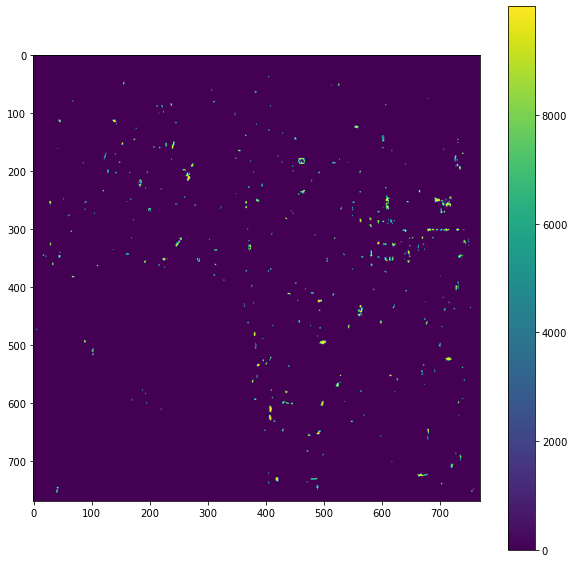

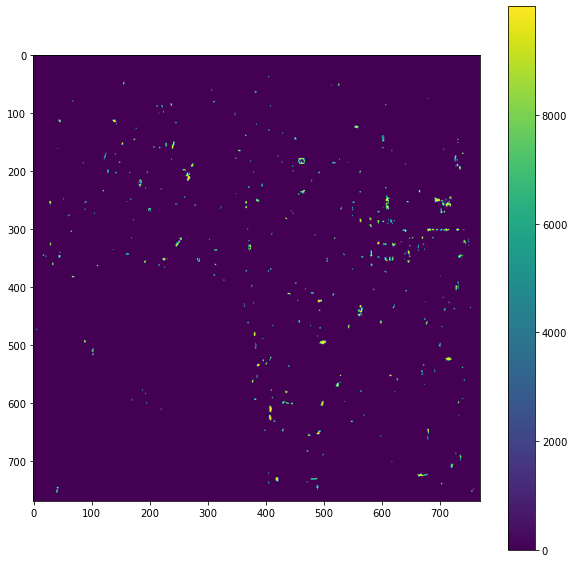

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(shade2)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(shade10[2])
plt.colorbar()

In [34]:
comb = np.append(shade0, shade1, axis=0)
comb = np.append(comb, np.moveaxis(shade2[..., np.newaxis],[0,1,2],[1,2,0]), axis=0)